# Statistical Methods for Machine Learning project

In [32]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

import math
import kagglehub
import shutil

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [39]:
!pip install torchmetrics

# Creation of training and test folders

In [33]:
if not os.path.exists('train'):
    # Download latest version
    path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
    print("Path to dataset files:", path)

    # creation of training and test folders
    ratio = 0.8
    subfolders = ['rock','paper','scissors']

    os.makedirs('train', exist_ok=True)
    os.makedirs('test', exist_ok=True)
    for subfolder in subfolders:
        subpath = os.path.join(path, subfolder)
        os.makedirs(os.path.join('train',subfolder))
        os.makedirs(os.path.join('test',subfolder))

        imgs = os.listdir(subpath)
        random.shuffle(imgs)

        train_size = int(0.8 * len(imgs))
        test_size = len(imgs) - train_size

        train_imgs = imgs[:train_size]
        test_imgs = imgs[train_size:]

        for i in train_imgs:
            shutil.copy(os.path.join(subpath,i), os.path.join('train',subfolder,i))
        for i in test_imgs:
            shutil.copy(os.path.join(subpath,i), os.path.join('test',subfolder,i))




(200, 300, 3)


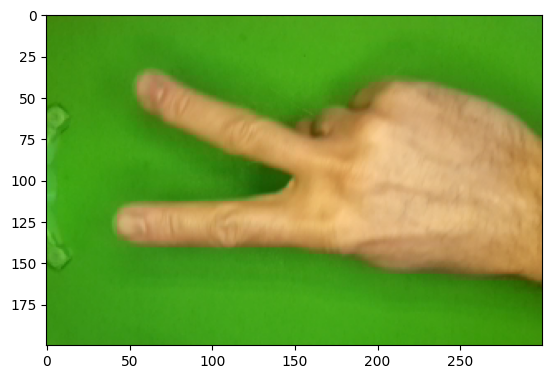

In [34]:
plt.figure()
folder = os.path.join('train', random.choice(['rock','paper','scissors']))
img_name = random.choice(os.listdir(folder))
img = io.imread(os.path.join(folder,img_name))
print( img.shape)
plt.imshow(img)
plt.show()

# Transformation and data augmentation

In [35]:
# no need to resize since all images have the same dimension (?)
# test set only transformed to tensor
# training set augmented with random transformations

test_transform = transforms.Compose([
    transforms.ToTensor()
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomRotation(degrees=(-20,20)),
])

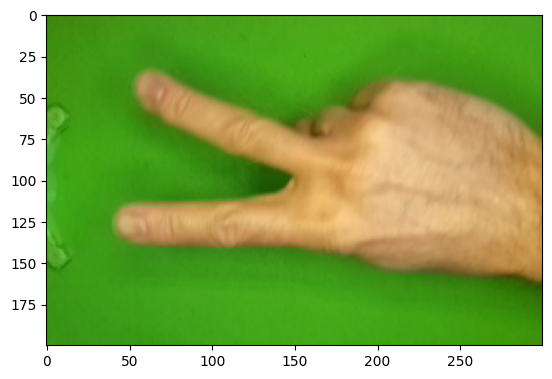

In [36]:
transformed_img = train_transform(img)
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

# DataLoader creation

In [37]:
batch_size = 9
train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='test', transform=test_transform)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size)

classes = train_dataset.classes

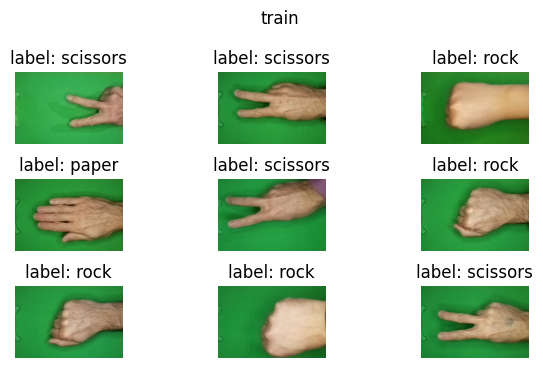

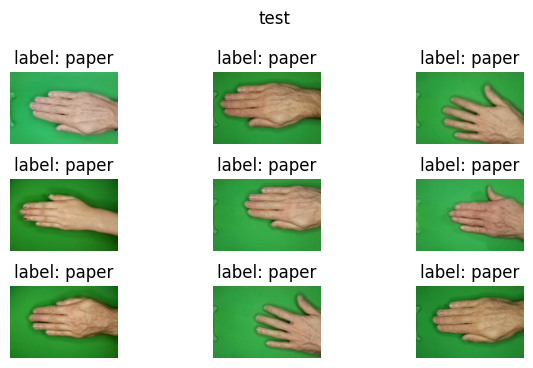

In [38]:
def show_batch(x, y, yh=None, title=None):
    col = math.floor(math.sqrt(len(x)))
    row = col+1
    for i in range(len(x)):
        ax = plt.subplot(row,col,i+1)
        plt.tight_layout()
        subtitle = 'label: ' + classes[int(y[i])]
        if (yh is not None):
            subtitle += '\nprediction: ' + classes[int(np.argmax(yh[i]))]
        ax.set_title(subtitle)
        ax.axis('off')
        plt.imshow(x[i].permute(1,2,0))
    if (title):
        plt.subplots_adjust(top=0.85)
        plt.suptitle(title)
    plt.show()

show_batch(*next(iter(train_dl)), title='train')
show_batch(*next(iter(test_dl)), title='test')

# Training function

In [40]:
from tqdm import tqdm
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall

def train_model(model, dataloaders,  criterion, optimizer, scheduler, num_epochs=25):
    stats = {
            'train_loss': [],
            'test_loss': [],
            'test_acc': [],
            'test_rec': [],
            'test_prec': []
    }
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)

        # TRAIN
        running_loss = 0
        for batch_index, (images, labels) in enumerate(tqdm(dataloaders['train'])):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            running_loss += loss.item()*images.size(0)
            optimizer.step()

        epoch_loss = running_loss / len(dataloaders['train'])
        stats['train_loss'].append(epoch_loss)

        # test
        acc = Accuracy(task="multiclass",num_classes=len(classes)).to(device)
        precision = Precision(task="multiclass", num_classes=len(classes), average='macro').to(device)
        recall = Recall(task="multiclass", num_classes=len(classes), average='macro').to(device)

        model.eval()
        with torch.no_grad():
            for images, labels in dataloaders['test']:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*images.size(0)
                _, preds = torch.max(outputs, 1)
                acc(preds, labels)
                precision(preds, labels)
                recall(preds, labels)

            test_loss = running_loss / len(dataloaders['test'])
            test_accuracy = acc.compute()
            test_precision = precision.compute()
            test_recall = recall.compute()

            stats['test_loss'].append(test_loss)
            stats['test_acc'].append(test_accuracy.to('cpu'))
            stats['test_rec'].append(test_recall.to('cpu'))
            stats['test_prec'].append(test_precision.to('cpu'))


        print(f"Train loss: {epoch_loss:.4f}")
        print(f"Test loss: {test_loss:.4f}")
        print(f"Test accuracy: {test_accuracy:.4f}")
        print(f"Test precision: {test_precision:.4f}")
        print(f"Test recall: {test_recall:.4f}")

    plt.plot(stats['train_loss'], 'bo-', label='train loss')
    plt.plot(stats['test_loss'], 'r+-', label='test loss')
    plt.show()

    plt.plot(stats['test_acc'])
    plt.plot(stats['test_rec'])
    plt.plot(stats['test_prec'])
    plt.show()

# Graph function

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def cm_plot(model, dl):
    y = []
    y_hat = []
    classes = dl.dataset.classes

    with torch.set_grad_enabled(False):
        for img, lbls in dl:
            output = net(img.to(device).float()).to('cpu').float()
            y.extend(lbls)
            pred = output.data.max(1, keepdim=True)[1]
            y_hat.extend(pred)

    cm = confusion_matrix(y, y_hat, labels=range(len(classes)))
    ConfusionMatrixDisplay(cm,display_labels=classes).plot()

# Network definition

In [42]:
# Simple net
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(32*50*75,128)
        self.fc2 = nn.Linear(128,3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Experiments

Epoch 0/9
----------


100%|██████████| 195/195 [00:06<00:00, 28.43it/s]


Train loss: 6.2835
Test loss: 27.7890
Test accuracy: 0.8998
Test precision: 0.8997
Test recall: 0.8992
Epoch 1/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.21it/s]


Train loss: 2.5055
Test loss: 11.4410
Test accuracy: 0.9453
Test precision: 0.9453
Test recall: 0.9450
Epoch 2/9
----------


100%|██████████| 195/195 [00:06<00:00, 31.06it/s]


Train loss: 1.3228
Test loss: 6.6704
Test accuracy: 0.9499
Test precision: 0.9504
Test recall: 0.9495
Epoch 3/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.22it/s]


Train loss: 0.9483
Test loss: 5.5603
Test accuracy: 0.9339
Test precision: 0.9371
Test recall: 0.9332
Epoch 4/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.34it/s]


Train loss: 0.6238
Test loss: 3.7785
Test accuracy: 0.9476
Test precision: 0.9479
Test recall: 0.9471
Epoch 5/9
----------


100%|██████████| 195/195 [00:06<00:00, 31.74it/s]


Train loss: 0.3136
Test loss: 3.3373
Test accuracy: 0.9339
Test precision: 0.9380
Test recall: 0.9331
Epoch 6/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.81it/s]


Train loss: 0.2231
Test loss: 2.0989
Test accuracy: 0.9636
Test precision: 0.9638
Test recall: 0.9637
Epoch 7/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.77it/s]


Train loss: 0.8300
Test loss: 4.5234
Test accuracy: 0.9567
Test precision: 0.9569
Test recall: 0.9569
Epoch 8/9
----------


100%|██████████| 195/195 [00:06<00:00, 31.16it/s]


Train loss: 0.3408
Test loss: 2.4113
Test accuracy: 0.9658
Test precision: 0.9665
Test recall: 0.9653
Epoch 9/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.41it/s]


Train loss: 0.2441
Test loss: 2.3109
Test accuracy: 0.9408
Test precision: 0.9403
Test recall: 0.9403


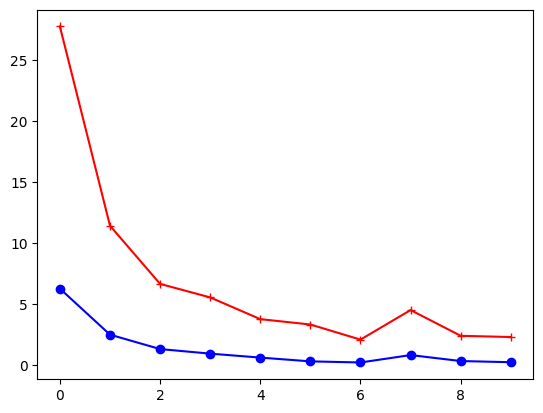

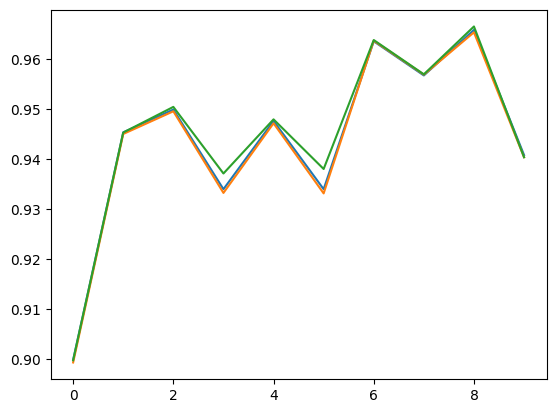

In [43]:
net = SimpleNet()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(net.parameters(), lr=1e-3)
# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


image_datasets = {'train' : train_dataset, 'test': test_dataset}

dls = {'train' : train_dl, 'test': test_dl}

dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}
train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

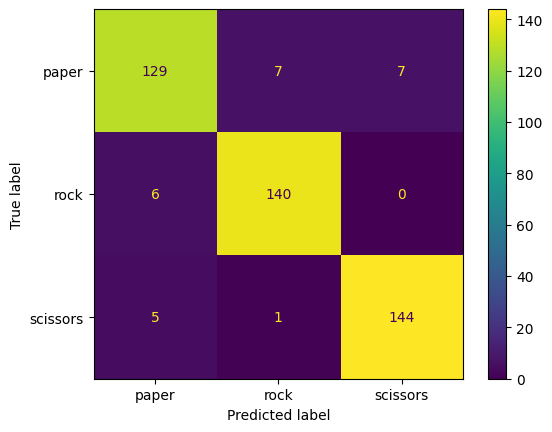

In [44]:
cm_plot(net, test_dl)

Size of tensor containing a batch of images is torch.Size([9, 3, 200, 300])


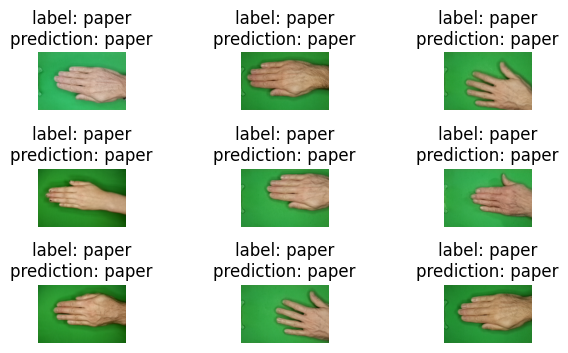

In [45]:
img,lbl=next(iter(test_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

with torch.set_grad_enabled(False):
    outputs = net(inputs)


if (device=='cpu'):
    show_batch(img,lbl,outputs)
else:
    show_batch(img,lbl,outputs.cpu().numpy())

